### Gruppo 4 Text Analytics 2022/23
- Simona Sette
- Giulio Canapa
- Sara Quattrone
- Diego Borsetto

# Classification 

Different classifiers have been tested with the aim to obtain the best results in terms of accuracy. 
Here will be shown the following classifiers: 
- Linear Support Vector with One VS One strategy and One VS Rest strategy;
- Random Forest;
- Naive Bayes;
>These classifier will be tested with both Word2Vec and CountVectorizer textual representation.

- Long short-term memory combined with CountVectorizer textual representation;



## CountVectorizer as Vectorizer

This section focuses on trying different classification algorithm (Linear SVC, OneVSOne and OneVSAll with Linear SVC, Random Forest and Naive Bayes) on the text vectorization obtained through CountVectorizer, wich converts a collection of text documents to a matrix of token counts.

## Import

In [1]:
import warnings
warnings.filterwarnings("ignore")
#per ignorare fit in cui mindf crea poche feature ma il valore di k passato al select best k supera il n di feature
import pandas as pd
import csv
import os.path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from nltk.stem import WordNetLemmatizer 
wnl = WordNetLemmatizer()
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
import re
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsOneClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
import nltk
from nltk import word_tokenize          
from nltk.corpus import stopwords
stopwords = nltk.corpus.stopwords.words('english')
import gensim
import multiprocessing
from gensim.models import Word2Vec
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.utils import pad_sequences
from keras.layers.core import  SpatialDropout1D
from keras.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV

In [2]:
# class to define a lemma tokenizer 
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, X_train_lista):
        return [self.wnl.lemmatize(t) for t in word_tokenize(X_train_lista)]

In [3]:
# class to perform a conversion from sparce matrix to dense (required by naive bayes)
class DenseTransformer():

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.todense()

## Data understanding and preparation

In [4]:
df = pd.read_csv("Multiclass_problem_7Classes.csv" ,sep=',', header=0)

Before proceeding with the classification, the consequences of the choice to carry out an undersampling will be shown graphically and a count of total and distinct lemmas and tokens will be shown, considering both the case in which the stopwords are removed and the case of non-removal.

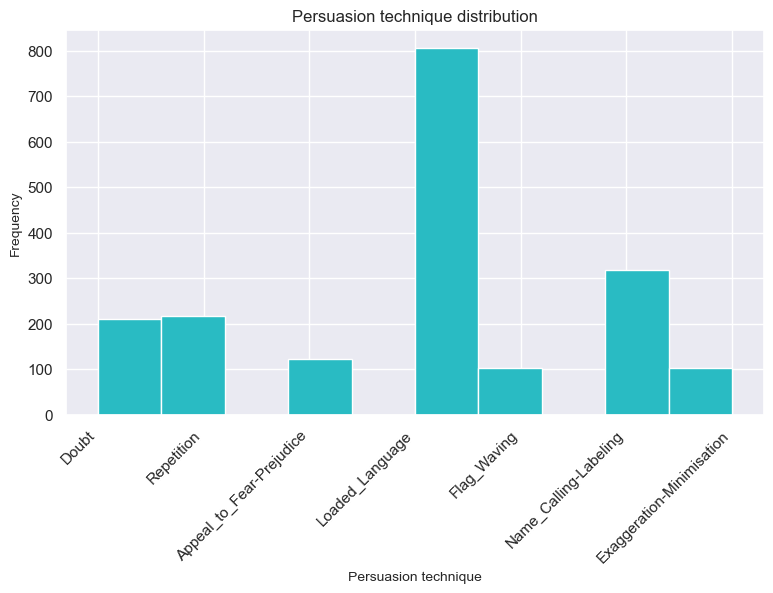

In [5]:
dist_or = df[df.columns.difference(['Article', 'Paragraph','ID'])]
x= 'Persuasion technique'
y= 'Frequency'
plt.rcParams["figure.figsize"] = [9,5]
plt.hist(dist_or['Technique'],color='#29bbc3')
plt.title('Persuasion technique distribution')
plt.xlabel(x, fontsize=10)
plt.ylabel(y, fontsize=10)
sns.set_style("darkgrid")
plt.xticks(rotation=45, ha='right')
plt.show()

Generation of dataframes containing persuasion techniques (y) and paragraph textual content (X).

In [6]:
y=df['Technique']

In [7]:
X=df.loc[:, df.columns == 'Text']

Performing Random Undersampling in order to reduce the majority class (Loaded_Language with 806 records).

In [8]:
undersample = RandomUnderSampler(sampling_strategy={'Name_Calling-Labeling': 318, 'Repetition': 218, 'Doubt': 210, 'Appeal_to_Fear-Prejudice': 122, 
                                                    'Exaggeration-Minimisation': 102, 'Flag_Waving': 102, 'Loaded_Language': 350})
# fit and apply the transform
X_under, y_under = undersample.fit_resample(X, y)

Post undersampling class frequency control:

In [9]:
print(Counter(y_under))

Counter({'Loaded_Language': 350, 'Name_Calling-Labeling': 318, 'Repetition': 218, 'Doubt': 210, 'Appeal_to_Fear-Prejudice': 122, 'Exaggeration-Minimisation': 102, 'Flag_Waving': 102})


Post undersamplng data distribution:

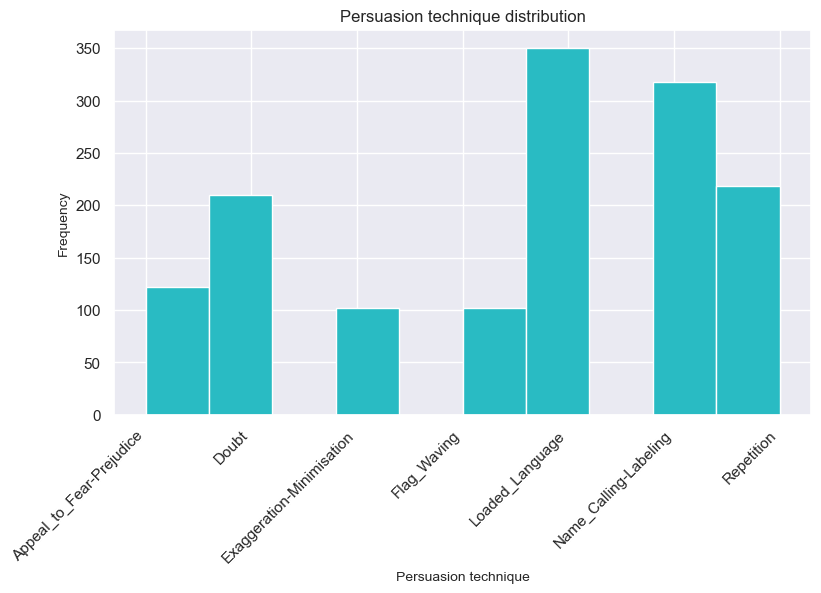

In [23]:
x= 'Persuasion technique'
y= 'Frequency'
plt.title('Persuasion technique distribution')
plt.rcParams["figure.figsize"] = [9,5]
plt.hist(y_under,color='#29bbc3')
plt.xlabel(x, fontsize=10)
plt.ylabel(y, fontsize=10)
sns.set_style("darkgrid")
plt.xticks(rotation=45, ha='right')
plt.show()## Distribuzione post Undersampling

In [10]:
#creation of a dataframe containing both the tokenized text and cleaned tokenized text
X_count = pd.DataFrame()
X_count['Text_TOK'] = X_under['Text'].apply(lambda x: gensim.utils.simple_preprocess(x))
X_count['Text_cleanTOK'] = [[w for w in frase if not w.lower() in stopwords] for frase in X_count["Text_TOK"]]
X_count

,Text_TOK,Text_cleanTOK
0,"[in, any, case, note, well, the, letter, to, m...","[case, note, well, letter, uk, home, office, s..."
1,"[if, person, dies, of, pneumonic, plague, and,...","[person, dies, pneumonic, plague, interred, to..."
2,"[that, will, likely, change, however]","[likely, change, however]"
3,"[members, of, the, group, and, advocates, say,...","[members, group, advocates, say, fear, could, ..."
4,"[whosoever, therefore, resisteth, the, power, ...","[whosoever, therefore, resisteth, power, resis..."
...,...,...
1417,"[it, seems, there, are, two, themes, running, ...","[seems, two, themes, running, document, establ..."
1418,"[even, sadder, however, is, the, fact, that, t...","[even, sadder, however, fact, smear, campaigns..."
1419,"[influential, roman, talk, him, up]","[influential, roman, talk]"
1420,"[see, this, is, why, they, should, be, honest,...","[see, honest, name, non, american, medical, as..."


In [13]:
print("Counts including stopwords")
TokTot=[]
for frase in X_count['Text_TOK']:
    for word in frase:
        TokTot.append(str(word))
print("total token count (not distinct) =",len(TokTot))

TokUnique= list(set(TokTot))
print("total token count (distinct) =",len(TokUnique))

lemtok=[] 
for word in TokTot:
        lem=str(wnl.lemmatize(word))
        lemtok.append(lem)
print("total lemmas count (not distinct)=",len(lemtok))

LemUnique= list(set(lemtok))
print("total lemmas count (distinct)=",len(LemUnique))

Counts including stopwords
total token count (not distinct) = 65968
total token count (distinct) = 8923
total lemmas count (not distinct)= 65968
total lemmas count (distinct)= 8095


In [15]:
print("Counts removing stopwords")
TokTotclean=[]
for frase in X_count['Text_cleanTOK']:
    for word in frase:
        TokTotclean.append(str(word))
print("total token count (not distinct)",len(TokTotclean))

TokUniqueClean= list(set(TokTotclean))
print("total token count (distinct)=",len(TokUniqueClean))

lemtokclean=[] 
for word in TokTotclean:
        lem=str(wnl.lemmatize(word))
        lemtokclean.append(lem)
print("total lemmas count (not distinct)=",len(lemtokclean))

LemUniqueclean= list(set(lemtokclean))
print("total lemmas count (distinct)",len(LemUniqueclean))

Counts removing stopwords
total token count (not distinct) 36890
total token count (distinct)= 8787
total lemmas count (not distinct)= 36890
total lemmas count (distinct) 7962


In [27]:
#set splitting in train set and test set (70% and 30%)
X_train, X_test, y_train, y_test = train_test_split(X_under,y_under,stratify=y_under,test_size=0.3, random_state=100)

We save both the paragraphs textual content of the train and test and their lables in lists.

In [28]:
X_train_lista = list()
for x in X_train['Text']:
    X_train_lista.append(str(x))
    
y_train_lista = list()
for i in y_train:
    y_train_lista.append(str(i))

X_test_lista = list()
for x in X_test['Text']:
    X_test_lista.append(str(x))
    
y_test_lista = list()
for i in y_test:
    y_test_lista.append(str(i))

------------------------------------------------------------

## __CountVectorizer for classification__

## Linear Support Vector Classifier

First grid search to find the optimal values for each parameter inside the pipe_parameters. 

GridSearchCV automatically performs a 5-fold cross validation.

In [11]:
pipe = Pipeline([
    ('vect', CountVectorizer(stop_words='english', strip_accents='ascii')),  # feature extraction 
    ('sel', SelectKBest(chi2)),  # feature selection
    ('tfidf', TfidfTransformer(smooth_idf=True, sublinear_tf=True)),  # weighting
    ('learner', LinearSVC())  # learning algorithm
])
pipe_parameters = [
    {'vect__min_df': (3, 5, 7),
    'vect__ngram_range': ((1,1), (1, 2), (1,3), (1,5)),
    'sel__k': (20, 50, 100, 300, 500, 700),
    'tfidf__norm': ("l1", "l2"),
    'learner__penalty' : ("l1", "l2"),
    'learner__loss': ('hinge', 'squared_hinge'),
    'learner__multi_class' : ('ovr', 'crammer_singer')}
]

grid = GridSearchCV(pipe, pipe_parameters, cv=2)
grid.fit(X_train_lista,y_train)
grid.best_params_

{'learner__loss': 'squared_hinge',
 'learner__multi_class': 'ovr',
 'learner__penalty': 'l2',
 'sel__k': 700,
 'tfidf__norm': 'l1',
 'vect__min_df': 3,
 'vect__ngram_range': (1, 3)}

Second and last grid search to try different CountVectorizer params configuration set: this was done to investigate how much an increasing number of linguistic factors considered could impact the final classifier accuracy.

In [14]:
pipe = Pipeline([
    ('vect', CountVectorizer(stop_words='english', strip_accents='ascii')),  # feature extraction 
    ('sel', SelectKBest(chi2, k=700)),  # feature selection
    ('tfidf', TfidfTransformer(norm='l1')),  # weighting
    ('learner', LinearSVC(loss='squared_hinge',multi_class='ovr',penalty='l2'))
     ])
pipe_parameters = [
    {},
    # minimum frequency inside the corpus
    {'vect__min_df' : [3]},
    # extract ngrams through the analyzer (token is the default setting)
    { 'vect__ngram_range' : (1,3)},
    # combination 
    {'vect__min_df' : [3], 'vect__ngram_range' : (1,3)}
     
]

grid = GridSearchCV(pipe, pipe_parameters, cv=2, scoring='accuracy')
grid.fit(X_train_lista,y_train)
print(grid.best_params_)
print(grid.best_score_)

{'vect__min_df': 3}
0.3417028274062043


The best CounVectorizer piped configuration resulted to be {'vect__min_df': 3} and it was finally implemented in the final training.

In [15]:
pipeline = Pipeline([
    ('vect', CountVectorizer(min_df=3, stop_words='english', strip_accents='ascii')),  # feature extraction
    ('sel', SelectKBest(chi2, k=700)),  # feature selection
    ('tfidf', TfidfTransformer(norm='l1')),  # weighting
    ('learner',  LinearSVC(loss='squared_hinge',multi_class='ovr',penalty='l2'))  # learning algorithm
])

pipeline.fit(X_train_lista,y_train)
predictions = pipeline.predict(X_test_lista)

print('Classification report:')
print(classification_report(y_test, predictions))
print('Confusion matrix:')
cm = confusion_matrix(y_test, predictions)
print(cm)

correct = 0
for prediction,true_label in zip(predictions, y_test):
    if prediction==true_label:
        correct += 1
print("accuracy=", correct/len(predictions))

Classification report:
                           precision    recall  f1-score   support

 Appeal_to_Fear-Prejudice       0.25      0.16      0.20        37
                    Doubt       0.39      0.35      0.37        63
Exaggeration-Minimisation       0.33      0.10      0.15        31
              Flag_Waving       0.46      0.35      0.40        31
          Loaded_Language       0.34      0.52      0.41       105
    Name_Calling-Labeling       0.38      0.37      0.37        95
               Repetition       0.45      0.38      0.41        65

                 accuracy                           0.37       427
                macro avg       0.37      0.32      0.33       427
             weighted avg       0.37      0.37      0.36       427

Confusion matrix:
[[ 6  4  2  0  8  9  8]
 [ 4 22  0  1 22 10  4]
 [ 2  2  3  3 14  6  1]
 [ 1  4  1 11  7  6  1]
 [ 6 14  2  1 55 17 10]
 [ 4  7  1  4 37 35  7]
 [ 1  4  0  4 21 10 25]]
accuracy= 0.36768149882903983


Finally, the classifier has also been implemented using the Wordnet lemmatizer as CountVectorizer tokenizer method and leaving the other pipeline components parameters unchanged:

In [35]:
pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer=LemmaTokenizer(),
                                strip_accents='ascii', 
                                stop_words = 'english', 
                                min_df = 3)),  
    ('sel', SelectKBest(chi2, k=700)),  # feature selection
    ('tfidf', TfidfTransformer(norm='l1')),  # weighting
    ('learner',  LinearSVC(loss='squared_hinge',multi_class='ovr',penalty='l2'))  # learning algorithm
])

pipeline.fit(X_train_lista,y_train)
predictions = pipeline.predict(X_test_lista)

print('Classification report:')
print(classification_report(y_test, predictions))
print('Confusion matrix:')
cm = confusion_matrix(y_test, predictions)
print(cm)

correct = 0
for prediction,true_label in zip(predictions, y_test):
    if prediction==true_label:
        correct += 1
print("accuracy=", correct/len(predictions))

Classification report:
                           precision    recall  f1-score   support

 Appeal_to_Fear-Prejudice       0.44      0.11      0.17        37
                    Doubt       0.44      0.38      0.41        63
Exaggeration-Minimisation       1.00      0.06      0.12        31
              Flag_Waving       0.60      0.48      0.54        31
          Loaded_Language       0.37      0.59      0.45       105
    Name_Calling-Labeling       0.34      0.44      0.38        95
               Repetition       0.45      0.31      0.37        65

                 accuracy                           0.40       427
                macro avg       0.52      0.34      0.35       427
             weighted avg       0.46      0.40      0.38       427

Confusion matrix:
[[ 4  2  0  0  5 20  6]
 [ 1 24  0  1 19 15  3]
 [ 0  2  2  2 15  9  1]
 [ 0  4  0 15  9  3  0]
 [ 2 12  0  1 62 19  9]
 [ 1  6  0  2 39 42  5]
 [ 1  4  0  4 20 16 20]]
accuracy= 0.3957845433255269


## Linear Support Vector Classifier with one-vs-one multiclass strategy

First grid search to find the optimal values for each parameter inside the pipe_parameters.

GridSearchCV automatically performs a 5-fold cross validation.

In [12]:
pipe = Pipeline([
    ('vect', CountVectorizer(stop_words='english', strip_accents='ascii')),  # feature extraction 
    ('sel', SelectKBest(chi2)),  # feature selection
    ('tfidf', TfidfTransformer(smooth_idf=True,sublinear_tf=True)),  # weighting
    ('learner', OneVsOneClassifier(LinearSVC(loss='squared_hinge',penalty='l2')))  # learning algorithm
])
pipe_parameters = [
    {'vect__min_df': (3, 5, 7),
    'vect__ngram_range': ((1,1), (1, 2), (1,3), (1,5)),
    'sel__k': (20, 50, 100, 300, 500, 700),
    'tfidf__norm': ("l1", "l2")}
]

grid = GridSearchCV(pipe, pipe_parameters, cv=2)
grid.fit(X_train_lista,y_train)
grid.best_params_

{'sel__k': 700,
 'tfidf__norm': 'l2',
 'vect__min_df': 3,
 'vect__ngram_range': (1, 2)}

Second and last grid search to try different CountVectorizer params configuration set: this was done to investigate how much an increasing number of linguistic factors considered could impact the final classifier accuracy.

In [13]:
pipe = Pipeline([
    ('vect', CountVectorizer(stop_words='english', strip_accents='ascii')),  # feature extraction 
    ('sel', SelectKBest(chi2, k=700)),  # feature selection
    ('tfidf', TfidfTransformer(norm='l2')),  # weighting  
    ('learner', OneVsOneClassifier(LinearSVC(loss='squared_hinge',penalty='l2')))  # learning algorithm
])
pipe_parameters = [
    {},
    # minimum frequency inside the corpus
    {'vect__min_df' : [3]},
    # extract ngrams through the analyzer (token is the default setting)
    {'vect__ngram_range' : (1,2)},
    # combination 
    {'vect__min_df' : [3], 'vect__ngram_range' : (1,2)},    
]


grid = GridSearchCV(pipe, pipe_parameters, cv=2, scoring='accuracy')
grid.fit(X_train_lista,y_train)
print(grid.best_params_)
print(grid.best_score_)

{'vect__min_df': 3}
0.3266547073606296


The best CounVectorizer piped configuration resulted to be {'vect__min_df': 3} and it was finally implemented in the final training.

In [14]:
pipeline = Pipeline([
    ('vect', CountVectorizer(min_df=3, stop_words='english', strip_accents='ascii')),  # feature extraction
    ('sel', SelectKBest(chi2, k=700)),  # feature selection
    ('tfidf', TfidfTransformer(norm='l2')),  # weighting
    ('learner',  OneVsOneClassifier(LinearSVC(loss='squared_hinge',multi_class='ovr',penalty='l2')))  # learning algorithm
])

pipeline.fit(X_train_lista,y_train)
predictions = pipeline.predict(X_test_lista)

print('Classification report:')
print(classification_report(y_test, predictions))
print('Confusion matrix:')
cm = confusion_matrix(y_test, predictions)
print(cm)

correct = 0
for prediction,true_label in zip(predictions, y_test):
    if prediction==true_label:
        correct += 1
print("accuracy=", correct/len(predictions))

Classification report:
                           precision    recall  f1-score   support

 Appeal_to_Fear-Prejudice       0.32      0.27      0.29        37
                    Doubt       0.32      0.29      0.30        63
Exaggeration-Minimisation       0.00      0.00      0.00        31
              Flag_Waving       0.73      0.52      0.60        31
          Loaded_Language       0.29      0.42      0.34       105
    Name_Calling-Labeling       0.30      0.31      0.30        95
               Repetition       0.42      0.35      0.38        65

                 accuracy                           0.33       427
                macro avg       0.34      0.31      0.32       427
             weighted avg       0.33      0.33      0.32       427

Confusion matrix:
[[10  4  5  1  8  1  8]
 [ 2 18  2  0 23 14  4]
 [ 2  3  0  0 15  7  4]
 [ 0  2  1 16  6  4  2]
 [ 9 12  3  1 44 27  9]
 [ 5 13  0  3 40 29  5]
 [ 3  5  2  1 15 16 23]]
accuracy= 0.32786885245901637


Finally, the classifier has also been implemented using the Wordnet lemmatizer as CountVectorizer tokenizer method and leaving the other pipeline components parameters unchanged:

In [16]:
pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer=LemmaTokenizer(),
                                strip_accents='ascii', 
                                stop_words = 'english',
                                min_df = 3)),  # feature extraction
    ('sel', SelectKBest(chi2, k=700)),  # feature selection
    ('tfidf', TfidfTransformer(norm='l2')),  # weighting
    ('learner',  OneVsOneClassifier(LinearSVC(loss='squared_hinge',penalty='l2')))  # learning algorithm
])

pipeline.fit(X_train_lista,y_train)
predictions = pipeline.predict(X_test_lista)

print('Classification report:')
print(classification_report(y_test, predictions))
print('Confusion matrix:')
cm = confusion_matrix(y_test, predictions)
print(cm)

correct = 0
for prediction,true_label in zip(predictions, y_test):
    if prediction==true_label:
        correct += 1
print("accuracy=", correct/len(predictions))

Classification report:
                           precision    recall  f1-score   support

 Appeal_to_Fear-Prejudice       0.28      0.22      0.24        37
                    Doubt       0.52      0.40      0.45        63
Exaggeration-Minimisation       0.08      0.03      0.05        31
              Flag_Waving       0.85      0.55      0.67        31
          Loaded_Language       0.33      0.44      0.37       105
    Name_Calling-Labeling       0.36      0.46      0.40        95
               Repetition       0.44      0.37      0.40        65

                 accuracy                           0.39       427
                macro avg       0.41      0.35      0.37       427
             weighted avg       0.40      0.39      0.38       427

Confusion matrix:
[[ 8  2  2  0 12  7  6]
 [ 2 25  1  0 19 12  4]
 [ 3  1  1  0 13 11  2]
 [ 2  1  1 17  5  3  2]
 [ 9  6  4  0 46 30 10]
 [ 3  9  3  2 28 44  6]
 [ 2  4  0  1 18 16 24]]
accuracy= 0.3864168618266979


## Random Forest

First grid search to find the optimal values for each parameter inside the pipe_parameters.

GridSearchCV automatically performs a 5-fold cross validation.

In [12]:
pipe = Pipeline([
    ('vect', CountVectorizer(stop_words='english', strip_accents='ascii')),  # feature extraction 
    ('sel', SelectKBest(chi2)),  # feature selection
    ('tfidf', TfidfTransformer(smooth_idf=True,sublinear_tf=True)),  # weighting
    ('learner', RandomForestClassifier(n_jobs=-1))  # learning algorithm
])
pipe_parameters = [
    {'vect__min_df': (3, 5, 7),
    'vect__ngram_range': ((1,1), (1, 2), (1,3), (1,5)),
    'sel__k': (20, 50, 100, 300, 500, 700),
    'tfidf__norm': ("l1", "l2"),
    'learner__n_estimators': (100,150),
    'learner__criterion': ("gini", "entropy", "log_loss"),
    'learner__min_samples_split': (2,7),
    'learner__min_samples_leaf': (2,7),
    'learner__max_features': ("sqrt", "log2", None)}
]

grid = GridSearchCV(pipe, pipe_parameters, cv=2)
grid.fit(X_train_lista,y_train)
grid.best_params_

{'learner__criterion': 'gini',
 'learner__max_features': 'log2',
 'learner__min_samples_leaf': 2,
 'learner__min_samples_split': 2,
 'learner__n_estimators': 150,
 'sel__k': 500,
 'tfidf__norm': 'l1',
 'vect__min_df': 3,
 'vect__ngram_range': (1, 3)}

Second and last grid search to try different CountVectorizer params configuration set: this was done to investigate how much an increasing number of linguistic factors considered could impact the final classifier accuracy.

In [13]:
pipe = Pipeline([
    ('vect', CountVectorizer(stop_words='english', strip_accents='ascii')),  # feature extraction 
    ('sel', SelectKBest(chi2, k=500)),  # feature selection
    ('tfidf', TfidfTransformer(norm='l1')),  # weighting 
    ('learner', RandomForestClassifier(criterion='gini', max_features='log2', min_samples_leaf= 2, min_samples_split= 2, n_estimators= 150))  # learning algorithm
])
pipe_parameters = [
    {},
    # minimum frequency inside the corpus
    {'vect__min_df' : [3]}, 
    # extract ngrams through the analyzer (token is the default setting)
    { 'vect__ngram_range' : (1,3)},
    # combination   
    {'vect__min_df' : [3], 'vect__ngram_range' : (1,3)},
]


grid = GridSearchCV(pipe, pipe_parameters, cv=2, scoring='accuracy')
grid.fit(X_train_lista,y_train)
print(grid.best_params_)
print(grid.best_score_)

{'vect__min_df': 3}
0.3105803495672832


The best CountVectorizer piped configuration resulted to be {'vect__min_df': 3} and it was finally implemented in the final training.

In [14]:
pipeline = Pipeline([
    ('vect', CountVectorizer(min_df=3, stop_words='english', strip_accents='ascii')),  # feature extraction
    ('sel', SelectKBest(chi2, k=500)),  # feature selection
    ('tfidf', TfidfTransformer(norm='l1')),  # weighting
    ('learner', RandomForestClassifier(criterion='gini', max_features='log2', min_samples_leaf= 2, min_samples_split= 2, n_estimators= 150))  # learning algorithm
])

pipeline.fit(X_train_lista,y_train)
predictions = pipeline.predict(X_test_lista)

print('Classification report:')
print(classification_report(y_test, predictions))
print('Confusion matrix:')
cm = confusion_matrix(y_test, predictions)
print(cm)

correct = 0
for prediction,true_label in zip(predictions, y_test):
    if prediction==true_label:
        correct += 1
print("accuracy=", correct/len(predictions))

Classification report:
                           precision    recall  f1-score   support

 Appeal_to_Fear-Prejudice       0.47      0.24      0.32        37
                    Doubt       0.33      0.25      0.29        63
Exaggeration-Minimisation       0.25      0.03      0.06        31
              Flag_Waving       0.52      0.42      0.46        31
          Loaded_Language       0.31      0.63      0.41       105
    Name_Calling-Labeling       0.30      0.25      0.27        95
               Repetition       0.57      0.31      0.40        65

                 accuracy                           0.35       427
                macro avg       0.39      0.31      0.32       427
             weighted avg       0.37      0.35      0.33       427

Confusion matrix:
[[ 9  3  0  0 18  4  3]
 [ 3 16  1  1 24 16  2]
 [ 0  3  1  2 17  7  1]
 [ 1  1  0 13 12  2  2]
 [ 3 10  2  4 66 19  1]
 [ 1  6  0  3 55 24  6]
 [ 2  9  0  2 23  9 20]]
accuracy= 0.34894613583138173


Finally, the classifier has also been implemented using the Wordnet lemmatizer as CountVectorizer tokenizer method and leaving the other pipeline components parameters unchanged:

In [18]:
pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer=LemmaTokenizer(),
                                strip_accents='ascii', 
                                stop_words = 'english', 
                                min_df = 3)),  # feature extraction 
    ('sel', SelectKBest(chi2, k=500)),  # feature selection
    ('tfidf', TfidfTransformer(norm='l1')),  # weighting
    ('learner', RandomForestClassifier(criterion='gini', max_features='log2', min_samples_leaf= 2, min_samples_split= 2, n_estimators= 150))  # learning algorithm
])

pipeline.fit(X_train_lista,y_train)
predictions = pipeline.predict(X_test_lista)

print('Classification report:')
print(classification_report(y_test, predictions))
print('Confusion matrix:')
cm = confusion_matrix(y_test, predictions)
print(cm)

correct = 0
for prediction,true_label in zip(predictions, y_test):
    if prediction==true_label:
        correct += 1
print("accuracy=", correct/len(predictions))

Classification report:
                           precision    recall  f1-score   support

 Appeal_to_Fear-Prejudice       0.62      0.22      0.32        37
                    Doubt       0.46      0.35      0.40        63
Exaggeration-Minimisation       0.00      0.00      0.00        31
              Flag_Waving       0.64      0.45      0.53        31
          Loaded_Language       0.32      0.69      0.44       105
    Name_Calling-Labeling       0.36      0.36      0.36        95
               Repetition       0.67      0.28      0.39        65

                 accuracy                           0.39       427
                macro avg       0.44      0.33      0.35       427
             weighted avg       0.43      0.39      0.37       427

Confusion matrix:
[[ 8  1  0  0 21  6  1]
 [ 0 22  0  1 24 14  2]
 [ 0  1  0  3 17  9  1]
 [ 2  1  0 14 11  2  1]
 [ 1 10  0  1 72 21  0]
 [ 1  7  1  1 47 34  4]
 [ 1  6  0  2 30  8 18]]
accuracy= 0.39344262295081966


## Gaussian Naive Bayes

First grid search to find the optimal values for each parameter inside the pipe_parameters.

GridSearchCV automatically performs a 5-fold cross validation.

In [31]:
pipe = Pipeline([
    ('vect', CountVectorizer(stop_words='english', strip_accents='ascii')),  # feature extraction 
    ('sel', SelectKBest(chi2)),  # feature selection
    ('tfidf', TfidfTransformer()),  # weighting  
    ('to_dense', DenseTransformer()),
    ('learner', GaussianNB())  # learning algorithm
])
pipe_parameters = [
    {'vect__min_df': (3, 5, 7),
    'vect__ngram_range': ((1,1), (1, 2), (1,3), (1,5)),
    'sel__k': (20, 50, 100, 300, 500, 700),
    'tfidf__norm': ("l1", "l2"),
    'learner__var_smoothing': [1e-11, 1e-10, 1e-9],
    'learner__priors': [None]}
]

grid = GridSearchCV(pipe, pipe_parameters, cv=2, scoring='accuracy')
grid.fit(X_train_lista,y_train)
print(grid.best_params_)
print(grid.best_score_)

{'learner__priors': None, 'learner__var_smoothing': 1e-10, 'sel__k': 700, 'tfidf__norm': 'l1', 'vect__min_df': 3, 'vect__ngram_range': (1, 1)}
0.3115581036419319


Since the best CountVectorizer piped configuration resulted to be 'vect__min_df': 3 and 'vect__ngram_range': (1, 1), and the value for ngram_range it's the default one, there was no need to implement a second grid search and we proceeded directly with the final training.

In [32]:
pipeline = Pipeline([
    ('vect', CountVectorizer(stop_words='english', strip_accents='ascii', min_df=3)),  # feature extraction
    ('sel', SelectKBest(chi2, k=700)),  # feature selection
    ('tfidf', TfidfTransformer(norm='l1')),  # weighting
    ('to_dense', DenseTransformer()), 
    ('learner', GaussianNB(priors= None,var_smoothing=1e-10)) # learning algorithm
])

pipeline.fit(X_train_lista,y_train)
predictions = pipeline.predict(X_test_lista)

print('Classification report:')
print(classification_report(y_test, predictions))
print('Confusion matrix:')
cm = confusion_matrix(y_test, predictions)
print(cm)

correct = 0
for prediction,true_label in zip(predictions, y_test):
    if prediction==true_label:
        correct += 1
print("accuracy=", correct/len(predictions))

Classification report:
                           precision    recall  f1-score   support

 Appeal_to_Fear-Prejudice       0.31      0.38      0.34        37
                    Doubt       0.32      0.30      0.31        63
Exaggeration-Minimisation       0.12      0.26      0.16        31
              Flag_Waving       0.17      0.29      0.21        31
          Loaded_Language       0.39      0.26      0.31       105
    Name_Calling-Labeling       0.33      0.24      0.28        95
               Repetition       0.40      0.40      0.40        65

                 accuracy                           0.30       427
                macro avg       0.29      0.30      0.29       427
             weighted avg       0.33      0.30      0.30       427

Confusion matrix:
[[14  4  4  4  4  2  5]
 [ 5 19  8  8  8  9  6]
 [ 2  5  8  5  5  3  3]
 [ 3  3  7  9  5  2  2]
 [ 8  8 21 11 27 17 13]
 [10 15 17  8 12 23 10]
 [ 3  5  1  9  8 13 26]]
accuracy= 0.29508196721311475


Finally, the classifier has also been implemented using the Wordnet lemmatizer as CountVectorizer tokenizer method and leaving the other pipeline components parameters unchanged:

In [38]:
pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer=LemmaTokenizer(),
                                strip_accents='ascii', # works 
                                stop_words = 'english', # works
                                min_df = 3)),  # feature extraction 
    ('sel', SelectKBest(chi2, k=700)),  # feature selection
    ('tfidf', TfidfTransformer(norm='l1')),  # weighting
    ('to_dense', DenseTransformer()), 
    ('learner', GaussianNB(priors= None,var_smoothing=1e-10)) # learning algorithm
])

pipeline.fit(X_train_lista,y_train)
predictions = pipeline.predict(X_test_lista)

print('Classification report:')
print(classification_report(y_test, predictions))
print('Confusion matrix:')
cm = confusion_matrix(y_test, predictions)
print(cm)

correct = 0
for prediction,true_label in zip(predictions, y_test):
    if prediction==true_label:
        correct += 1
print("accuracy=", correct/len(predictions))

Classification report:
                           precision    recall  f1-score   support

 Appeal_to_Fear-Prejudice       0.28      0.46      0.35        37
                    Doubt       0.34      0.33      0.34        63
Exaggeration-Minimisation       0.09      0.16      0.12        31
              Flag_Waving       0.19      0.29      0.23        31
          Loaded_Language       0.42      0.25      0.31       105
    Name_Calling-Labeling       0.43      0.32      0.36        95
               Repetition       0.36      0.40      0.38        65

                 accuracy                           0.31       427
                macro avg       0.30      0.32      0.30       427
             weighted avg       0.35      0.31      0.32       427

Confusion matrix:
[[17  2  1  4  4  4  5]
 [10 21  5  8  8  6  5]
 [ 4  8  5  4  3  1  6]
 [ 1  4  6  9  4  2  5]
 [16 10 17  6 26 17 13]
 [10 11 16  8  8 30 12]
 [ 2  6  3  9  9 10 26]]
accuracy= 0.31381733021077285


----------------------------------------------------------------------

## __Word2Vec for classification__

### Data preprocessing

In [36]:
# tokenize paragraphs with genshin
X_under['Text_TOK'] = X_under['Text'].apply(lambda x: gensim.utils.simple_preprocess(x))
# remove stopwords from tokenized sentences
X_under['Text_cleanTOK'] = [[w for w in frase if not w.lower() in stopwords] for frase in X_under["Text_TOK"]]
# Label mapping
y_under_mapped=y_under.map({'Appeal_to_Fear-Prejudice': 0,'Doubt': 1,'Exaggeration-Minimisation': 2,'Flag_Waving': 3,'Loaded_Language': 4,'Name_Calling-Labeling': 5,'Repetition': 6})

In [37]:
X_under

,Text,Text_TOK,Text_cleanTOK
0,"Whosoever therefore resisteth the power, resis...","[whosoever, therefore, resisteth, the, power, ...","[whosoever, therefore, resisteth, power, resis..."
1,So it is crucial that you and your pro-gun fri...,"[so, it, is, crucial, that, you, and, your, pr...","[crucial, pro, gun, friends, get, polls]"
2,"Since Oct. 1, 2009, ERO has removed more than ...","[since, oct, ero, has, removed, more, than, fo...","[since, oct, ero, removed, foreign, fugitives,..."
3,Symptoms of the plague include a very high fev...,"[symptoms, of, the, plague, include, very, hig...","[symptoms, plague, include, high, fever, cough..."
4,Email This field is for validation purposes an...,"[email, this, field, is, for, validation, purp...","[email, field, validation, purposes, left, unc..."
...,...,...,...
1417,"Of course, Infowars' Paul Joseph Watson simply...","[of, course, infowars, paul, joseph, watson, s...","[course, infowars, paul, joseph, watson, simpl..."
1418,“I think we are all counting on the district a...,"[think, we, are, all, counting, on, the, distr...","[think, counting, district, attorney, position..."
1419,"And as we go into the Council, you know that o...","[and, as, we, go, into, the, council, you, kno...","[go, council, know, first, day, council, cardi..."
1420,It’s funny that the buzzword of the day in Rom...,"[it, funny, that, the, buzzword, of, the, day,...","[funny, buzzword, day, rome, autonomy, shall, ..."


In [38]:
# defining a dataframe containing the tokenized cleaned text
Text_cleanTOK_df = X_under.loc[:, X_under.columns == 'Text_cleanTOK']

In [39]:
# overriding previous splitted frames since we performed a different preprocessing respect to the count vectorizer
X_train, X_test, y_train, y_test = train_test_split(Text_cleanTOK_df, y_under_mapped,stratify=y_under_mapped,test_size=0.3, random_state=100)

In [40]:
# validation creation: 
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train ,stratify=y_train,test_size=0.1, random_state=100)

### Starting the embedding creation process

In [41]:
# creating a list of tokenized and cleaned sentences 
sents_corpus=[]
for i in Text_cleanTOK_df['Text_cleanTOK']:
    sents_corpus.append(i)

The Word2Vec embedding actually needs 3 parameters to be setted:
    
- size - size of the word vectors we want;

- window - number words before and after the focus word that it’ll consider as context for the word;

- min_count - the number of times a word must appear in our corpus in order to create a word vector.

Through a nested for loop different combination for each possibile parameters value were implemented for all the previously seen classifiers.  

In [42]:
Vector_feature_size=[100,300,500,700]
windows_set=[2,5,7]
min_c_set= [2,5]

print("\n Current Parameters:")
for dim in Vector_feature_size:
    for w in windows_set:
        for m in min_c_set:
            print("--------------------------------------------------------------------------------")
            print("\n Vector_feature_size = ",dim)
            print("\n Window = ", w)
            print("\n Min_count =", m)
            
            cores = multiprocessing.cpu_count() # Count the number of cores in a computer
            model = Word2Vec(sentences=sents_corpus, vector_size=dim, window=w, min_count=m, workers=cores-1)

                #vocaboli nel vocabolario estratti dal w2v
            words = set(model.wv.index_to_key )
                #per frase in riga di xtrain, per ogni token nella frase, se il token è presente nel vocabolario: inserisci nel xtrainVect (che sarà un numpy array)la versione numpy array del vettore generato dal modello word2vec per quel token
                #alla fine nei due vect ci sarà il vettore calcolato da word2vec per i singoli token contenuti nelle frasi del train e test

            X_train_vect = np.array([np.array([model.wv[token] for token in frase if token in words]) for frase in X_train["Text_cleanTOK"]])
        #qui è sul validation NON SUL TEST perchè vogliamo valutare le prestazioni --> X_val["Text_cleanTOK"]
            X_val_vect = np.array([np.array([model.wv[token] for token in frase if token in words]) for frase in X_val["Text_cleanTOK"]])
                # Compute sentence vectors with zero padding when owrd in frase is not in vocab

            X_train_vect_z = []
                #per ogni array dentro il maxi aray x.train.vect se la dimensione dell'array non è 0 appendi l'array alla nuova lista, se è 0 appendi un array di zeri di dimensione 100
            for v in X_train_vect:
                if v.size:
                        #inserisce zeri fino a un massimo di 100 quando il numero di elementi è <100
                        #refcheck=False serve per evitare errore reference, doc: https://numpy.org/doc/1.20/reference/generated/numpy.ndarray.resize.html#numpy.ndarray.resize
                    v.resize(dim,refcheck=False)
                        # se vuoi usare una media: X_train_vect_avg.append(v.mean(axis=0))
                    X_train_vect_z.append(v)
                else:
                    X_train_vect_z.append(np.zeros(dim, dtype=float))

            X_val_vect_z = []
            for v in X_val_vect:
                if v.size:
                    v.resize(dim,refcheck=False)
                    X_val_vect_z.append(v)
                else:
                    X_val_vect_z.append(np.zeros(dim, dtype=float))

            #Classifiers-------------------------------------------------------

            print("\n\n Performances obtained for the different classifiers:\n\n")

            #LINEARSVC
            SVC = LinearSVC(loss='squared_hinge',multi_class='ovr',penalty='l2')
            SVC_model = SVC.fit(X_train_vect_z, y_train.values.ravel())
            # Use the trained model to make predictions on the test data
            y_pred = SVC_model.predict(X_val_vect_z)

            correct = 0
            for pred,true_label in zip(y_val,y_pred):
                if pred==true_label:
                    correct += 1
            print("\n - The SVC classifier got an accuracy of ",correct/len(y_pred))


            #ONEVSONE


            OVO =  OneVsOneClassifier(LinearSVC(loss='squared_hinge',multi_class='ovr',penalty='l2'))
            OVO_model = OVO.fit(X_train_vect_z, y_train.values.ravel())
            # Use the trained model to make predictions on the test data
            y_pred = OVO_model.predict(X_val_vect_z)

            correct = 0
            for pred,true_label in zip(y_val,y_pred):
                if pred==true_label:
                    correct += 1
            print("\n - The OVO SVC classifier got an accuracy of ",correct/len(y_pred))


            #RANDOM FOREST

            
            rf =RandomForestClassifier(criterion='gini', max_features='log2', min_samples_leaf= 2, min_samples_split= 2, n_estimators= 150)
            rf_model = rf.fit(X_train_vect_z, y_train.values.ravel())
            # Use the trained model to make predictions on the test data
            y_pred = rf_model.predict(X_val_vect_z)
            correct = 0
            for pred,true_label in zip(y_val,y_pred):
                if pred==true_label:
                    correct += 1
            print("\n - The Random Forest classifier got an accuracy of ",correct/len(y_pred))


            #NAIVE BAYES

            gnb = GaussianNB(priors= None,var_smoothing=1e-10)
            NaiveB = gnb.fit(X_train_vect_z, y_train.values.ravel())
            y_pred = NaiveB.predict(X_val_vect_z)
            correct = 0
            for pred,true_label in zip(y_val,y_pred):
                if pred==true_label:
                    correct += 1
            print("\n - The Gaussian Naive Bayes classifier got an accuracy of ",correct/len(y_pred))



 Current Parameters:
--------------------------------------------------------------------------------

 Vector_feature_size =  100

 Window =  2

 Min_count = 2


 Performances obtained for the different classifiers:



 - The SVC classifier got an accuracy of  0.24

 - The OVO SVC classifier got an accuracy of  0.25

 - The Random Forest classifier got an accuracy of  0.17

 - The Gaussian Naive Bayes classifier got an accuracy of  0.21
--------------------------------------------------------------------------------

 Vector_feature_size =  100

 Window =  2

 Min_count = 5


 Performances obtained for the different classifiers:



 - The SVC classifier got an accuracy of  0.23

 - The OVO SVC classifier got an accuracy of  0.24

 - The Random Forest classifier got an accuracy of  0.19

 - The Gaussian Naive Bayes classifier got an accuracy of  0.11
--------------------------------------------------------------------------------

 Vector_feature_size =  100

 Window =  5

 Min_count 

The choice fell on the parameters set that returned the best results in terms of accuracy on as many classifiers as possible, which was:
- size: 500;
- window: 7;
- min_count: 2.

In [35]:
# Count the number of cores in a computer
cores = multiprocessing.cpu_count() 
#defining the definitive Word2Vec embedding
model = Word2Vec(sentences=sents_corpus, vector_size=500, window=7, min_count=2, workers=cores-1)

#words in the dictionary extracted from the w2v
words = set(model.wv.index_to_key )

#per sentence in line of xtrain, for each token in the sentence, if the token is present in the vocabulary: insert in the xtrainVect (which will be a numpy array) the numpy array version of the vector generated by the word2vec template for that token
#at the end in the two "vect" there will be the vector calculated by word2vec for the single tokens contained in the train and test sentences
X_train_vect = np.array([np.array([model.wv[token] for token in frase if token in words]) for frase in X_train["Text_cleanTOK"]])
X_test_vect = np.array([np.array([model.wv[token] for token in frase if token in words]) for frase in X_test["Text_cleanTOK"]])


# Compute sentence vectors with zero padding when the word in paragraph is not in the vocabulary (words)

X_train_vect_z = []
#for each array inside x_train_vect, if the size of the array is not 0 append the array to the new list, if it is 0 append an array of zeros of size 100
for v in X_train_vect:
    if v.size:
        #inserts zeros up to a maximum of 100 when the number of elements is less then 100
        #refcheck=Falseto avoid reference error, doc: https://numpy.org/doc/1.20/reference/generated/numpy.ndarray.resize.html#numpy.ndarray.resize
        v.resize(500,refcheck=False)
        X_train_vect_z.append(v)
    else:
        X_train_vect_z.append(np.zeros(500, dtype=float))

#same procedure carried out above for train data
X_test_vect_z = []
for v in X_test_vect:
    if v.size:
        v.resize(500,refcheck=False)
        X_test_vect_z.append(v)
    else:
        X_test_vect_z.append(np.zeros(500, dtype=float))


Classifiers training with final embedding:

### Linear Support Vector Classifier

In [25]:
SVC = LinearSVC(loss='squared_hinge',multi_class='ovr',penalty='l2')
SVC_model = SVC.fit(X_train_vect_z, y_train.values.ravel())
y_pred = SVC_model.predict(X_test_vect_z)

correct = 0
for pred,true_label in zip(y_test,y_pred):
    if pred==true_label:
        correct += 1
print(correct/len(y_pred))
print('Classification report:')
print(classification_report(y_test, y_pred))
print('Confusion matrix:')
cm = confusion_matrix(y_test, y_pred)
print(cm)

0.2529274004683841
Classification report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        37
           1       0.00      0.00      0.00        63
           2       0.00      0.00      0.00        31
           3       0.00      0.00      0.00        31
           4       0.25      0.92      0.40       105
           5       0.24      0.12      0.16        95
           6       0.00      0.00      0.00        65

    accuracy                           0.25       427
   macro avg       0.07      0.15      0.08       427
weighted avg       0.12      0.25      0.13       427

Confusion matrix:
[[ 0  0  0  0 35  2  0]
 [ 0  0  0  0 53 10  0]
 [ 0  0  0  0 27  4  0]
 [ 0  0  0  0 28  3  0]
 [ 0  0  0  0 97  8  0]
 [ 0  0  0  0 84 11  0]
 [ 0  0  0  0 57  8  0]]


### Linear Support Vector Classifier with one-vs-one multiclass strategy

In [26]:
OVO =  OneVsOneClassifier(LinearSVC(loss='squared_hinge',multi_class='ovr',penalty='l2'))
OVO_model = OVO.fit(X_train_vect_z, y_train.values.ravel())
y_pred = OVO_model.predict(X_test_vect_z)

correct = 0
for pred,true_label in zip(y_test,y_pred):
    if pred==true_label:
        correct += 1
print(correct/len(y_pred))
print('Classification report:')
print(classification_report(y_test, y_pred))
print('Confusion matrix:')
cm = confusion_matrix(y_test, y_pred)
print(cm)

0.2505854800936768
Classification report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        37
           1       0.00      0.00      0.00        63
           2       0.00      0.00      0.00        31
           3       0.00      0.00      0.00        31
           4       0.25      0.92      0.40       105
           5       0.24      0.11      0.15        95
           6       0.00      0.00      0.00        65

    accuracy                           0.25       427
   macro avg       0.07      0.15      0.08       427
weighted avg       0.11      0.25      0.13       427

Confusion matrix:
[[ 0  0  0  0 35  2  0]
 [ 0  0  0  0 54  9  0]
 [ 0  0  0  0 27  4  0]
 [ 0  0  0  0 28  3  0]
 [ 0  0  0  0 97  8  0]
 [ 0  0  0  0 85 10  0]
 [ 0  0  0  0 59  6  0]]


### Random Forest

In [28]:
rf = RandomForestClassifier(criterion='gini', max_features='log2', min_samples_leaf= 2, min_samples_split= 2, n_estimators= 150)
rf_model = rf.fit(X_train_vect_z, y_train.values.ravel())
y_pred = rf_model.predict(X_test_vect_z)
correct = 0
for pred,true_label in zip(y_test,y_pred):
    if pred==true_label:
        correct += 1
print(correct/len(y_pred))
print('Classification report:')
print(classification_report(y_test, y_pred))
print('Confusion matrix:')
cm = confusion_matrix(y_test, y_pred)
print(cm)

0.24824355971896955
Classification report:
              precision    recall  f1-score   support

           0       0.11      0.03      0.04        37
           1       0.19      0.11      0.14        63
           2       0.25      0.13      0.17        31
           3       0.15      0.06      0.09        31
           4       0.26      0.48      0.34       105
           5       0.24      0.26      0.25        95
           6       0.30      0.26      0.28        65

    accuracy                           0.25       427
   macro avg       0.22      0.19      0.19       427
weighted avg       0.23      0.25      0.22       427

Confusion matrix:
[[ 1  3  1  2 17  9  4]
 [ 1  7  2  2 30 12  9]
 [ 1  3  4  3 12  7  1]
 [ 1  1  0  2 13 11  3]
 [ 3  9  1  2 50 27 13]
 [ 2 11  8  1 39 25  9]
 [ 0  3  0  1 32 12 17]]


### Gaussian Naive Bayes 

In [29]:
gnb = GaussianNB(priors= None,var_smoothing=1e-11)
NaiveB = gnb.fit(X_train_vect_z, y_train.values.ravel())
y_pred = NaiveB.predict(X_test_vect_z)
correct = 0
for pred,true_label in zip(y_test,y_pred):
    if pred==true_label:
        correct += 1
print(correct/len(y_pred))
print('Classification report:')
print(classification_report(y_test, y_pred))
print('Confusion matrix:')
cm = confusion_matrix(y_test, y_pred)
print(cm)

0.10070257611241218
Classification report:
              precision    recall  f1-score   support

           0       0.11      0.68      0.19        37
           1       0.12      0.06      0.08        63
           2       0.06      0.13      0.08        31
           3       0.00      0.00      0.00        31
           4       0.00      0.00      0.00       105
           5       0.33      0.01      0.02        95
           6       0.10      0.14      0.11        65

    accuracy                           0.10       427
   macro avg       0.10      0.15      0.07       427
weighted avg       0.12      0.10      0.06       427

Confusion matrix:
[[25  1  4  0  0  0  7]
 [29  4 14  0  0  1 15]
 [14  4  4  0  0  0  9]
 [19  4  5  0  0  0  3]
 [53  9 15  0  0  1 27]
 [49  5 17  0  0  1 23]
 [42  5  9  0  0  0  9]]


------------------------------------------------------------------------------

## Long short-term memory NN

The lable one hot encoding process is necessary since the layer dimension number must coincide with the number of the model output layers.

In [31]:
Y_tot = pd.get_dummies(y_under)
print('Shape of label tensor:', Y_tot.shape)

Shape of label tensor: (1422, 7)


In [33]:
# select Text attribute values (textual paragraphs)
Text = X_under.loc[:, X_under.columns == 'Text']
# overriding previous splitted frames since we performed a different preprocessing (one-hot encoded lables)
X_train, X_test, y_train, y_test = train_test_split(Text,Y_tot.values,stratify=Y_tot.values,test_size=0.3, random_state=100)

We save both the paragraphs textual content of the train and test and their lables in lists.

In [34]:
X_train_lista = list()
for x in X_train['Text']:
    X_train_lista.append(str(x))
    
X_test_lista = list()
for x in X_test['Text']:
    X_test_lista.append(str(x))

The CountVectorizer defined with cleaning and minimum frequency was employed in order to fed the NN classifier.

In [35]:
# convert the paragraphs to a matrix of token counts
vectorizer = CountVectorizer(min_df=3, strip_accents="ascii", stop_words='english')
#fit on the train set and trasform on both train and test set
vectorizer.fit(X_train_lista)
X_train_lista_vect_ =vectorizer.transform(X_train_lista)
X_test_lista_vect_ = vectorizer.transform(X_test_lista)

In [37]:
# convert to numpy array type
X_train_lista_vect=X_train_lista_vect_.toarray()
X_test_lista_vect=X_test_lista_vect_.toarray()

In [39]:
# defining the maximum size of vectors for each word
maxlen=500

In [40]:
# features padding
x_train = pad_sequences(X_train_lista_vect, maxlen=maxlen)
x_test = pad_sequences(X_test_lista_vect, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

x_train shape: (995, 500)
x_test shape: (427, 500)
y_train shape: (995, 7)
y_test shape: (427, 7)


### LSTM model definition

After different trials with the possible model parameters, the following have been choosen:

In [67]:
max_features = 1422 #Size of the vocabulary
embedding_dims = 100 #vectors long 100 to represent each word
maxlen=500
hidden_dims = 40 
batch_size = 100
epochs = 100

In [68]:
print('Build model...')
model = Sequential()

#Embedding layer
model.add(Embedding(max_features, embedding_dims, input_length=maxlen))

#LSTM layer with 40 memory units (smart neurons)
model.add(LSTM(hidden_dims, dropout=0.2, recurrent_dropout=0.2))

#because the one-hot encoded target the softmax activation function was chosen (Softmax converts a vector of values to a probability distribution)
model.add(Dense(7, activation='softmax'))

#loss choise is categorical_crossentropy because this is a multiclass problem 
model.compile(loss="categorical_crossentropy", optimizer= "adam", metrics=['accuracy'])

model.summary()

Build model...
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 500, 100)          142200    
                                                                 
 lstm_11 (LSTM)              (None, 40)                22560     
                                                                 
 dense_11 (Dense)            (None, 7)                 287       
                                                                 
Total params: 165,047
Trainable params: 165,047
Non-trainable params: 0
_________________________________________________________________


In [69]:
print('Train...')
history= model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          #shuffle is a boolean and defines whether to shuffle the training data before each epoch
          shuffle=True,
          validation_split=0.1,
          #early stopping provides the training phase from overfitting:
          #min_delta : minimum change in the monitored quantity to qualify as an improvement
          #patience : number of epochs with no improvement after which training will be stopped
          callbacks=[EarlyStopping(monitor='val_loss',patience=2, min_delta=0.01)])

Train...
Epoch 1/100
9/9 [==============================] - 18s 2s/step - loss: 1.9203 - accuracy: 0.2000 - val_loss: 1.8596 - val_accuracy: 0.2800
Epoch 2/100
9/9 [==============================] - 16s 2s/step - loss: 1.8672 - accuracy: 0.2179 - val_loss: 1.7805 - val_accuracy: 0.2800
Epoch 3/100
9/9 [==============================] - 16s 2s/step - loss: 1.8493 - accuracy: 0.2402 - val_loss: 1.7780 - val_accuracy: 0.2600
Epoch 4/100
9/9 [==============================] - 16s 2s/step - loss: 1.8478 - accuracy: 0.2447 - val_loss: 1.7819 - val_accuracy: 0.2600


Finally, the model is executed on the test set:

In [70]:
accr = model.evaluate(x_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

14/14 [==============================] - 2s 89ms/step - loss: 1.8425 - accuracy: 0.2459
Test set
  Loss: 1.843
  Accuracy: 0.246
